# (Legacy) LSTM_2.ipynb

此 notebook 的核心逻辑已抽成模块 `fyp_trading/`，并可用 `python run_lstm2_pipeline.py` 一键运行与输出到 `outputs/`。

- 保留原因：历史对照/实验记录
- 推荐用法：以后优先使用模块化脚本与 `strategy_*.ipynb` 做对比



Device: cpu
Data range: 2022-10-13 ~ 2025-10-13, N=736
Simple features ready. Total samples after dropna: 686, num_features=16
Class counts (Down, Neutral, Up): {0: 145, 1: 378, 2: 143}
Fold metrics (head):


,fold,test_start,test_end,up_acc,down_acc,dir_acc_on_signals,coverage,num_pred_up,num_pred_down,num_pred_ud,test_size
0,0,2024-04-17,2024-05-17,NaN,0.000000,0.000000,0.857143,0,18,18,21
1,1,2024-05-20,2024-06-18,NaN,NaN,NaN,0.000000,0,0,0,21
2,2,2024-06-19,2024-07-18,NaN,NaN,NaN,0.000000,0,0,0,21
3,3,2024-07-19,2024-08-16,NaN,0.454545,0.454545,0.523810,0,11,11,21
4,4,2024-08-19,2024-09-17,NaN,0.307692,0.307692,0.619048,0,13,13,21



CV summary (focus on Up/Down):


,up_acc,down_acc,dir_acc_on_signals,coverage
mean,0.238095,0.192672,0.198350,0.460317
std,NaN,0.148391,0.138319,0.465411
min,0.238095,0.000000,0.000000,0.000000
max,0.238095,0.454545,0.454545,1.000000


Backtest (last ~1Y) stats:


days                         252.000000
total_return                  -0.114136
buyhold_total_return           0.447195
annualized_return             -0.114136
buyhold_annualized_return      0.447195
annualized_volatility          0.231543
sharpe_ratio                  -0.411398
max_drawdown                  -0.211963
avg_trade_day_return          -0.000721
coverage                       0.519841
proba_threshold                0.570000
min_holding_period             2.000000
transaction_cost_bp            2.000000
dtype: float64

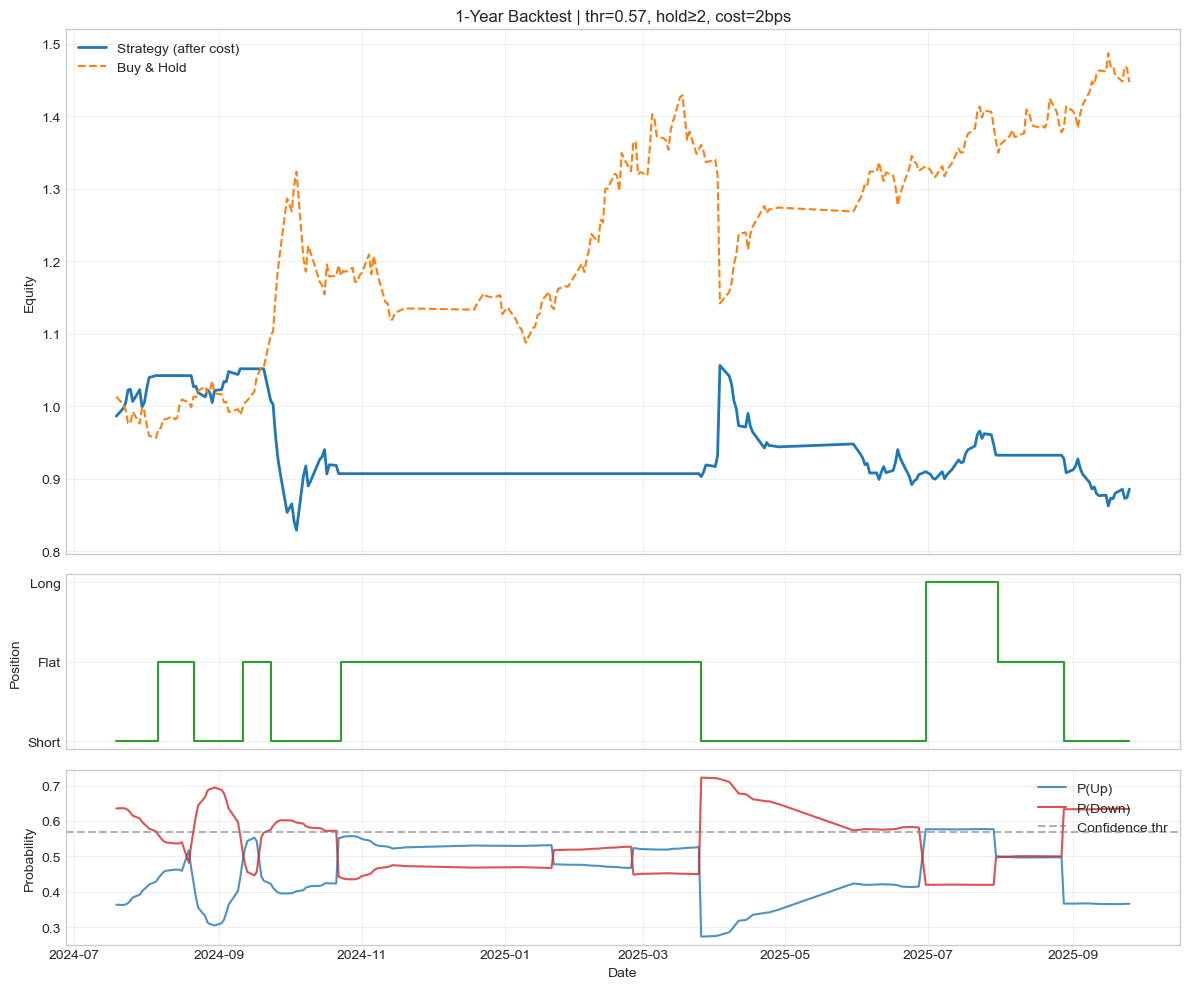

Directional accuracy on predicted signals: 0.179

Confusion matrix (rows true, cols pred) for signals only:


,Pred Down,Pred Up
True Down,21,3
True Up,35,5



Classification report (signals only):
              precision    recall  f1-score   support

        Down      0.169     0.875     0.284        24
          Up      0.238     0.125     0.164        40

   micro avg      0.179     0.406     0.249        64
   macro avg      0.204     0.500     0.224        64
weighted avg      0.212     0.406     0.209        64



In [6]:
# %% [markdown]
# # LSTM Pipeline (3-class) with Simple Features (SMA, Var, RSI, MACD, Bollinger), Walk-Forward CV, and 1-Year Backtest

import warnings
warnings.filterwarnings("ignore")

import os, math, random, copy
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd

import yfinance as yf

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

plt.style.use('seaborn-v0_8-whitegrid') if 'seaborn-v0_8-whitegrid' in plt.style.available else plt.style.use('ggplot')
sns.set_palette("Set2")

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau


# %% Reproducibility and device
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print("Device:", device)


# %%
@dataclass
class LabelingConfig:
    use_dynamic_threshold: bool = True
    vol_window: int = 20
    min_vol: float = 1e-4
    k_dynamic: float = 0.8                          # 阈值 = k × rolling vol


@dataclass
class TrainConfig:
    epochs: int = 100
    batch_size: int = 64
    patience: int = 15
    lr: float = 1e-3
    weight_decay: float = 1e-4
    lr_factor: float = 0.5
    lr_patience: int = 8
    lr_min: float = 1e-5
    grad_clip: float = 1.0
    verbose: bool = False

    hidden_size: int = 64
    num_layers: int = 2
    dropout: float = 0.4

    # 训练损失仅计算 Up/Down（Neutral 不计入）
    neutral_class_id: int = 1  # 0=Down, 1=Neutral, 2=Up


@dataclass
class PipelineConfig:
    ticker: str = "2800.HK"
    period: str = "3y"
    interval: str = "1d"
    lookback: int = 30

    train_window: int = 250
    val_size: int = 21
    test_size: int = 21
    step_size: Optional[int] = 21

    horizon: int = 1  # 预测 T+1
    proba_threshold: float = 0.57  # 置信度门限：低于该值判为“未判定”

    # 回测
    min_holding_period: int = 2
    transaction_cost_bp: float = 2.0
    backtest_days: int = 252  # 约 1 年交易日


LABEL_CFG = LabelingConfig()
TRAIN_CFG = TrainConfig()
PIPE_CFG = PipelineConfig()
if PIPE_CFG.step_size is None:
    PIPE_CFG.step_size = PIPE_CFG.test_size


# %% Data Fetching
def fetch_prices(ticker: str, period: str = "3y", interval: str = "1d") -> pd.DataFrame:
    tk = yf.Ticker(ticker)
    df = tk.history(period=period, interval=interval, auto_adjust=True)
    if df is None or df.empty:
        end = pd.Timestamp.today().normalize()
        start = end - pd.Timedelta(days=5 * 370)
        df = tk.history(start=start, end=end, interval=interval, auto_adjust=True)
    if df is None or df.empty:
        raise RuntimeError(f"Cannot fetch data for {ticker}.")
    df.index = pd.to_datetime(df.index).tz_localize(None)
    return df[["Open", "High", "Low", "Close", "Volume"]].copy()


df_raw = fetch_prices(PIPE_CFG.ticker, PIPE_CFG.period, PIPE_CFG.interval)
print(f"Data range: {df_raw.index.min().date()} ~ {df_raw.index.max().date()}, N={len(df_raw)}")
df_raw.tail()


# %% Technical Indicators (only the ones we keep)
def ema(series: pd.Series, span: int):
    return series.ewm(span=span, adjust=False).mean()

def rsi(series: pd.Series, period: int = 14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/period, adjust=False).mean().replace(0, np.nan)
    rs = roll_up / roll_down
    return 100 - (100 / (1 + rs))

def macd(close: pd.Series, fast=12, slow=26, signal=9):
    ema_fast = ema(close, fast)
    ema_slow = ema(close, slow)
    macd_line = ema_fast - ema_slow
    signal_line = ema(macd_line, signal)
    hist = macd_line - signal_line
    return macd_line, signal_line, hist

def bollinger_bands(close, period=20, num_std=2):
    mid = close.rolling(period).mean()
    sd = close.rolling(period).std()
    upper = mid + num_std * sd
    lower = mid - num_std * sd
    bandwidth = (upper - lower) / mid
    percent_b = (close - lower) / (upper - lower)
    return mid, upper, lower, bandwidth, percent_b


# %% Feature Engineering (Simple)
def build_features(df: pd.DataFrame, horizon: int = 1, use_log_return: bool = True) -> Tuple[pd.DataFrame, List[str]]:
    c = df["Close"].copy()

    feat = pd.DataFrame(index=df.index)

    feat["logret_1d"] = np.log(c / c.shift(1))

    feat["sma_5"] = c.rolling(5).mean()
    feat["sma_10"] = c.rolling(10).mean()
    feat["sma_20"] = c.rolling(20).mean()
    feat["sma_50"] = c.rolling(50).mean()

    feat["var_5d"] = feat["logret_1d"].rolling(5).var()
    feat["var_10d"] = feat["logret_1d"].rolling(10).var()
    feat["var_20d"] = feat["logret_1d"].rolling(20).var()

    # RSI
    feat["rsi_14"] = rsi(c, 14)

    # MACD
    macd_line, signal_line, macd_hist = macd(c)
    feat["macd"] = macd_line
    feat["macd_signal"] = signal_line
    feat["macd_hist"] = macd_hist

    # Bollinger Bands
    bb_mid, bb_up, bb_lo, bb_bw, bb_pb = bollinger_bands(c, 20, 2)
    feat["bb_mid"] = bb_mid
    feat["bb_upper"] = bb_up
    feat["bb_lower"] = bb_lo
    feat["bb_bw"] = bb_bw
    feat["bb_percent_b"] = bb_pb

    # 目标：下一期收益
    if use_log_return:
        next_ret = np.log(c.shift(-horizon) / c)
    else:
        next_ret = c.pct_change(horizon).shift(-horizon)

    feat = feat.replace([np.inf, -np.inf], np.nan)
    data = feat.copy()
    data["next_return"] = next_ret

    # 明确控制模型特征列（排除 logret_1d，但保留在 data 里供打标使用）
    feature_cols = [
        "sma_5", "sma_10", "sma_20", "sma_50",
        "var_5d", "var_10d", "var_20d",
        "rsi_14",
        "macd", "macd_signal", "macd_hist",
        "bb_mid", "bb_upper", "bb_lower", "bb_bw", "bb_percent_b",
    ]

    data = data.dropna().copy()
    print(f"Simple features ready. Total samples after dropna: {len(data)}, num_features={len(feature_cols)}")
    return data, feature_cols


feat_df_all, feature_cols_all = build_features(df_raw, horizon=PIPE_CFG.horizon, use_log_return=True)
feat_df_all.tail()


# %% Labeling: 3-class with Dynamic Threshold
CLASS_ID_DOWN = 0
CLASS_ID_NEUTRAL = 1
CLASS_ID_UP = 2
NUM_CLASSES = 3

def apply_labeling(feat_df: pd.DataFrame, label_cfg: LabelingConfig) -> pd.Series:
    if label_cfg.use_dynamic_threshold:
        roll_vol = feat_df["logret_1d"].rolling(label_cfg.vol_window).std().shift(1)
        thresholds = (label_cfg.k_dynamic * roll_vol).clip(lower=label_cfg.min_vol)
    else:
        thresholds = pd.Series(label_cfg.k_dynamic, index=feat_df.index, dtype=float)

    labels = pd.Series(np.nan, index=feat_df.index, dtype=float)
    labels[feat_df["next_return"] >= thresholds] = CLASS_ID_UP
    labels[feat_df["next_return"] <= -thresholds] = CLASS_ID_DOWN
    labels[(feat_df["next_return"] > -thresholds) & (feat_df["next_return"] < thresholds)] = CLASS_ID_NEUTRAL
    return labels

feat_df_labeled = feat_df_all.copy()
feat_df_labeled["target_class"] = apply_labeling(feat_df_labeled, LABEL_CFG)
feat_df_labeled = feat_df_labeled.dropna(subset=["target_class"]).copy()
feat_df_labeled["target_class"] = feat_df_labeled["target_class"].astype(int)

class_counts = feat_df_labeled["target_class"].value_counts().sort_index()
print("Class counts (Down, Neutral, Up):", class_counts.to_dict())


# %% Sequence Builder and Standardization
def make_sequences(
    feat_df: pd.DataFrame,
    feature_cols: List[str],
    lookback: int,
    label_cols: List[str]
) -> Tuple[np.ndarray, Dict[str, np.ndarray], pd.DatetimeIndex]:
    X_2d = feat_df[feature_cols].astype(np.float32).values
    dates = feat_df.index
    N = len(feat_df)
    if N < lookback:
        raise ValueError(f"Insufficient samples: N={N} < lookback={lookback}")

    X_list = []
    labels_dict = {col: [] for col in label_cols}
    idx_list = []

    for end in range(lookback - 1, N):
        start = end - lookback + 1
        X_list.append(X_2d[start:end + 1])
        idx_list.append(dates[end])
        for col in label_cols:
            labels_dict[col].append(feat_df.iloc[end][col])

    X_seq = np.stack(X_list).astype(np.float32)
    labels_dict = {col: np.asarray(vals) for col, vals in labels_dict.items()}
    seq_index = pd.DatetimeIndex(idx_list)
    return X_seq, labels_dict, seq_index

def fit_scaler_3d(X_train: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    flat = X_train.reshape(-1, X_train.shape[-1])
    mean = flat.mean(axis=0)
    std = flat.std(axis=0)
    std = np.where(std < 1e-12, 1e-12, std)
    return mean.astype(np.float32), std.astype(np.float32)

def transform_3d(X: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
    return (X - mean[None, None, :]) / std[None, None, :]


# %% LSTM Model and Masked Loss (Up/Down only)
class LSTMMultiClassifier(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 64, num_layers: int = 2, dropout: float = 0.4):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.act = nn.ReLU()
        self.out = nn.Linear(hidden_size, NUM_CLASSES)

    def forward(self, x):
        out, _ = self.lstm(x)
        h = out[:, -1, :]
        h = self.dropout(h)
        h = self.act(self.fc1(h))
        logits = self.out(h)
        return logits


def masked_cross_entropy(
    logits: torch.Tensor,
    target: torch.Tensor,
    neutral_class_id: int,
    class_weights: Optional[torch.Tensor] = None
) -> torch.Tensor:
    # 仅对 Up/Down 计算损失
    mask = target != neutral_class_id
    if mask.sum() == 0:
        return torch.zeros((), device=logits.device)
    logits_sel = logits[mask]
    target_sel = target[mask]
    return nn.functional.cross_entropy(logits_sel, target_sel, weight=class_weights)


def make_loader(
    X: np.ndarray, y: np.ndarray, batch_size: int, shuffle: bool
) -> DataLoader:
    X_t = torch.from_numpy(X.astype(np.float32))
    y_t = torch.from_numpy(y.astype(np.int64))
    ds = TensorDataset(X_t, y_t)
    return DataLoader(
        ds, batch_size=batch_size, shuffle=shuffle, num_workers=0,
        pin_memory=torch.cuda.is_available()
    )


def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    cfg: TrainConfig,
    class_weights: Optional[torch.Tensor]
) -> Tuple[nn.Module, Dict[str, List[float]]]:
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scheduler = ReduceLROnPlateau(
        optimizer, mode='min', factor=cfg.lr_factor, patience=cfg.lr_patience, min_lr=cfg.lr_min
    )

    best_state = copy.deepcopy(model.state_dict())
    best_val = float('inf')
    no_improve = 0
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, cfg.epochs + 1):
        model.train()
        train_loss = 0.0
        n_train = 0
        for xb, yb in train_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)
            optimizer.zero_grad()
            logits = model(xb)
            loss = masked_cross_entropy(logits, yb, cfg.neutral_class_id, class_weights)
            loss.backward()
            if cfg.grad_clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
            n_train += xb.size(0)
        train_loss = train_loss / max(n_train, 1)

        # 验证（同样只算 Up/Down）
        model.eval()
        val_loss = 0.0
        n_val = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)
                logits = model(xb)
                loss = masked_cross_entropy(logits, yb, cfg.neutral_class_id, class_weights)
                val_loss += loss.item() * xb.size(0)
                n_val += xb.size(0)
        val_loss = val_loss / max(n_val, 1)

        scheduler.step(val_loss)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        if cfg.verbose and (epoch == 1 or epoch % 10 == 0):
            cur_lr = optimizer.param_groups[0]["lr"]
            print(f"Epoch {epoch:03d} | train {train_loss:.6f} | val {val_loss:.6f} | lr {cur_lr:.2e}")

        if val_loss + 1e-12 < best_val:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= cfg.patience:
                if cfg.verbose:
                    print(f"Early stop at epoch {epoch}, best_val={best_val:.6f}")
                break

    model.load_state_dict(best_state)
    return model, history


def predict_logits(model: nn.Module, X: np.ndarray, batch_size: int = 256) -> np.ndarray:
    model = model.to(device)
    model.eval()
    outputs = []
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            xb = torch.from_numpy(X[i:i+batch_size].astype(np.float32)).to(device)
            logits = model(xb)
            outputs.append(logits.cpu().numpy())
    return np.concatenate(outputs, axis=0)

def softmax_np(logits: np.ndarray) -> np.ndarray:
    logits = logits - logits.max(axis=1, keepdims=True)
    exp = np.exp(logits)
    return exp / exp.sum(axis=1, keepdims=True)


# %% Walk-Forward Validation (Fixed Window)
def fixed_window_cv(
    X_seq_all: np.ndarray,
    y_all: np.ndarray,
    seq_index: pd.DatetimeIndex,
    cfg_pipe: PipelineConfig,
    cfg_train: TrainConfig
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    metrics = []
    preds_list = []

    N = len(X_seq_all)
    start_index = cfg_pipe.train_window + cfg_pipe.val_size
    fold_id = 0

    for test_start in range(start_index, N - cfg_pipe.test_size + 1, cfg_pipe.step_size):
        train_end = test_start
        val_start = train_end - cfg_pipe.val_size
        train_start = val_start - cfg_pipe.train_window
        test_end = test_start + cfg_pipe.test_size
        if train_start < 0:
            continue

        X_train = X_seq_all[train_start:val_start]
        y_train = y_all[train_start:val_start]
        X_val = X_seq_all[val_start:train_end]
        y_val = y_all[val_start:train_end]
        X_test = X_seq_all[test_start:test_end]
        y_test = y_all[test_start:test_end]
        test_dates = seq_index[test_start:test_end]

        # 确保训练/验证中存在足够的 Up/Down
        mask_ud_train = y_train != cfg_train.neutral_class_id
        mask_ud_val = y_val != cfg_train.neutral_class_id
        if mask_ud_train.sum() < 20 or mask_ud_val.sum() < 5:
            fold_id += 1
            continue

        # 标准化（仅用训练集统计量）
        mean, std = fit_scaler_3d(X_train)
        X_train_sc = transform_3d(X_train, mean, std)
        X_val_sc = transform_3d(X_val, mean, std)
        X_test_sc = transform_3d(X_test, mean, std)

        # 类别权重（仅 Down/Up）
        counts = np.bincount(y_train[mask_ud_train], minlength=NUM_CLASSES)
        w_down = counts.sum() / max(1.0, 2 * counts[CLASS_ID_DOWN])
        w_up = counts.sum() / max(1.0, 2 * counts[CLASS_ID_UP])
        class_weights = torch.tensor(
            [w_down, 0.0, w_up], device=device, dtype=torch.float32
        )

        # 模型
        model = LSTMMultiClassifier(
            input_size=X_train_sc.shape[-1],
            hidden_size=cfg_train.hidden_size,
            num_layers=cfg_train.num_layers,
            dropout=cfg_train.dropout
        )

        train_loader = make_loader(X_train_sc, y_train, cfg_train.batch_size, shuffle=True)
        val_loader = make_loader(X_val_sc, y_val, cfg_train.batch_size, shuffle=False)

        model, _ = train_model(model, train_loader, val_loader, cfg_train, class_weights)

        # 测试预测
        logits_test = predict_logits(model, X_test_sc, batch_size=256)
        proba_test = softmax_np(logits_test)

        # 概率门限：低于门限则“未判定（Neutral）”
        maxp = proba_test.max(axis=1)
        pred_raw = proba_test.argmax(axis=1)
        pred_class = pred_raw.copy()
        pred_class[maxp < cfg_pipe.proba_threshold] = CLASS_ID_NEUTRAL

        # 指标（仅对模型给出 Up/Down 信号的样本计算方向正确率）
        y_true = y_test
        mask_pred_up = pred_class == CLASS_ID_UP
        mask_pred_down = pred_class == CLASS_ID_DOWN
        mask_pred_ud = mask_pred_up | mask_pred_down

        up_acc = accuracy_score(y_true[mask_pred_up], pred_class[mask_pred_up]) if mask_pred_up.any() else np.nan
        down_acc = accuracy_score(y_true[mask_pred_down], pred_class[mask_pred_down]) if mask_pred_down.any() else np.nan
        directional_acc = accuracy_score(y_true[mask_pred_ud], pred_class[mask_pred_ud]) if mask_pred_ud.any() else np.nan
        coverage = mask_pred_ud.mean()  # 给出方向性信号的覆盖率

        metrics.append({
            "fold": fold_id,
            "test_start": test_dates[0],
            "test_end": test_dates[-1],
            "up_acc": up_acc,
            "down_acc": down_acc,
            "dir_acc_on_signals": directional_acc,
            "coverage": coverage,
            "num_pred_up": int(mask_pred_up.sum()),
            "num_pred_down": int(mask_pred_down.sum()),
            "num_pred_ud": int(mask_pred_ud.sum()),
            "test_size": len(X_test_sc),
        })

        fold_pred = pd.DataFrame({
            "fold": fold_id,
            "date": test_dates,
            "actual_class": y_true,
            "pred_class": pred_class,
            "proba_down": proba_test[:, CLASS_ID_DOWN],
            "proba_neutral": proba_test[:, CLASS_ID_NEUTRAL],
            "proba_up": proba_test[:, CLASS_ID_UP],
        })
        preds_list.append(fold_pred)

        fold_id += 1
        del model
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    metrics_df = pd.DataFrame(metrics)
    preds_df = pd.concat(preds_list, ignore_index=True) if preds_list else pd.DataFrame()
    return metrics_df, preds_df


# %% Prepare Data with Simple Features and Run Walk-Forward CV
feat_df_selected = feat_df_labeled.copy()
selected_cols = feature_cols_all.copy()

# 构造序列
X_seq, label_dict, seq_index = make_sequences(
    feat_df_selected,
    feature_cols=selected_cols,
    lookback=PIPE_CFG.lookback,
    label_cols=["target_class", "next_return"]
)
y_all = label_dict["target_class"].astype(np.int64)

# 走期验证
cv_metrics, cv_preds = fixed_window_cv(
    X_seq_all=X_seq,
    y_all=y_all,
    seq_index=seq_index,
    cfg_pipe=PIPE_CFG,
    cfg_train=TRAIN_CFG
)

print("Fold metrics (head):")
display(cv_metrics.head())

if not cv_metrics.empty:
    summary = cv_metrics[["up_acc", "down_acc", "dir_acc_on_signals", "coverage"]].agg(["mean", "std", "min", "max"])
    print("\nCV summary (focus on Up/Down):")
    display(summary)
else:
    print("No valid folds produced. Consider adjusting windows or thresholds.")


# %% Backtest: 1-Year Simulation
def generate_positions_from_proba(proba: np.ndarray, proba_threshold: float, min_holding_period: int) -> np.ndarray:
    proba_down = proba[:, CLASS_ID_DOWN]
    proba_up = proba[:, CLASS_ID_UP]
    raw_signal = np.zeros(len(proba), dtype=int)
    up_mask = (proba_up >= proba_threshold) & (proba_up >= proba_down)
    down_mask = (proba_down >= proba_threshold) & (proba_down > proba_up)
    raw_signal[up_mask] = 1
    raw_signal[down_mask] = -1

    positions = np.zeros(len(proba), dtype=int)
    holding = 0
    current_pos = 0

    for i in range(len(proba)):
        if holding > 0:
            positions[i] = current_pos
            holding -= 1
            continue
        new_signal = raw_signal[i]
        if new_signal != 0:
            current_pos = new_signal
            positions[i] = current_pos
            holding = max(min_holding_period - 1, 0)
        else:
            current_pos = 0
            positions[i] = 0
            holding = 0
    return positions


def prepare_backtest_df(cv_preds: pd.DataFrame, feat_df_selected: pd.DataFrame) -> pd.DataFrame:
    df = cv_preds.sort_values("date").copy()

    # 确保左表 date 列
    if "date" not in df.columns:
        cand = [c for c in df.columns if c.lower() in ("date", "datetime", "time", "timestamp")]
        if cand:
            df = df.rename(columns={cand[0]: "date"})
        else:
            raise ValueError("cv_preds does not contain a 'date' column.")
    df["date"] = pd.to_datetime(df["date"]).dt.tz_localize(None)

    # 右表：从 feat_df_selected 索引和 next_return 构造 date
    ret_df = feat_df_selected[["next_return"]].reset_index()
    first_col = ret_df.columns[0]
    if first_col != "date":
        ret_df = ret_df.rename(columns={first_col: "date"})
    ret_df["date"] = pd.to_datetime(ret_df["date"]).dt.tz_localize(None)

    bt = df.merge(ret_df, how="left", on="date")

    # 简单收益
    bt["simple_return"] = np.exp(bt["next_return"].fillna(0.0)) - 1.0
    return bt


def backtest_last_year(
    cv_preds: pd.DataFrame,
    feat_df_selected: pd.DataFrame,
    cfg: PipelineConfig
) -> Tuple[pd.DataFrame, Dict[str, float]]:
    if cv_preds.empty:
        raise ValueError("Empty predictions for backtest.")

    bt = prepare_backtest_df(cv_preds, feat_df_selected)

    # 取最近约 1 年 OOS 预测
    if len(bt) > cfg.backtest_days:
        bt = bt.iloc[-cfg.backtest_days:].copy()

    proba_array = bt[["proba_down", "proba_neutral", "proba_up"]].values
    bt["position"] = generate_positions_from_proba(
        proba_array, cfg.proba_threshold, cfg.min_holding_period
    )

    # 策略日收益
    bt["strategy_simple_return"] = bt["position"] * bt["simple_return"]

    # 交易成本（bps）
    position_change = bt["position"].diff().abs()
    position_change.iloc[0] = abs(bt["position"].iloc[0])
    cost_rate = cfg.transaction_cost_bp / 10000.0
    bt["transaction_cost"] = position_change * cost_rate
    bt["strategy_after_cost"] = bt["strategy_simple_return"] - bt["transaction_cost"]

    # 权益曲线
    bt["strategy_equity"] = (1 + bt["strategy_after_cost"]).cumprod()
    bt["buyhold_equity"] = (1 + bt["simple_return"]).cumprod()

    # 统计
    total_days = len(bt)
    strategy_final = bt["strategy_equity"].iloc[-1]
    buyhold_final = bt["buyhold_equity"].iloc[-1]
    years = max(total_days / 252, 1 / 252)

    daily_mean = bt["strategy_after_cost"].mean()
    daily_std = bt["strategy_after_cost"].std()

    stats = {
        "days": total_days,
        "total_return": strategy_final - 1.0,
        "buyhold_total_return": buyhold_final - 1.0,
        "annualized_return": strategy_final ** (1 / years) - 1.0,
        "buyhold_annualized_return": buyhold_final ** (1 / years) - 1.0,
        "annualized_volatility": daily_std * np.sqrt(252),
        "sharpe_ratio": (daily_mean / daily_std) * np.sqrt(252) if daily_std > 1e-8 else np.nan,
        "max_drawdown": (bt["strategy_equity"] / bt["strategy_equity"].cummax() - 1.0).min(),
        "avg_trade_day_return": bt.loc[bt["position"] != 0, "strategy_after_cost"].mean() if (bt["position"] != 0).any() else np.nan,
        "coverage": (bt["position"] != 0).mean(),
        "proba_threshold": cfg.proba_threshold,
        "min_holding_period": cfg.min_holding_period,
        "transaction_cost_bp": cfg.transaction_cost_bp
    }
    return bt, stats


bt_df, bt_stats = backtest_last_year(cv_preds, feat_df_selected, PIPE_CFG)
print("Backtest (last ~1Y) stats:")
display(pd.Series(bt_stats))


# %% Backtest Visualization (1-Year)
def plot_backtest(bt_df: pd.DataFrame, cfg: PipelineConfig):
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True, gridspec_kw={"height_ratios": [3, 1, 1]})

    # 权益曲线
    ax0 = axes[0]
    ax0.plot(bt_df["date"], bt_df["strategy_equity"], label="Strategy (after cost)", color="tab:blue", linewidth=2)
    ax0.plot(bt_df["date"], bt_df["buyhold_equity"], label="Buy & Hold", color="tab:orange", linestyle="--")
    ax0.set_ylabel("Equity")
    ax0.set_title(f"1-Year Backtest | thr={cfg.proba_threshold:.2f}, hold≥{cfg.min_holding_period}, cost={cfg.transaction_cost_bp:.0f}bps")
    ax0.legend(loc="best")
    ax0.grid(True, alpha=0.3)

    # 仓位
    ax1 = axes[1]
    ax1.step(bt_df["date"], bt_df["position"], where="post", color="tab:green", linewidth=1.5)
    ax1.set_ylabel("Position")
    ax1.set_yticks([-1, 0, 1])
    ax1.set_yticklabels(["Short", "Flat", "Long"])
    ax1.grid(True, alpha=0.3)

    # 概率
    ax2 = axes[2]
    ax2.plot(bt_df["date"], bt_df["proba_up"], label="P(Up)", color="tab:blue", alpha=0.8)
    ax2.plot(bt_df["date"], bt_df["proba_down"], label="P(Down)", color="tab:red", alpha=0.8)
    ax2.axhline(cfg.proba_threshold, color="gray", linestyle="--", alpha=0.6, label="Confidence thr")
    ax2.set_ylabel("Probability")
    ax2.set_xlabel("Date")
    ax2.legend(loc="upper right")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_backtest(bt_df, PIPE_CFG)


def directional_report(preds: pd.DataFrame) -> None:
    df = preds.sort_values("date").copy()
    mask = (df["pred_class"] == CLASS_ID_UP) | (df["pred_class"] == CLASS_ID_DOWN)
    df_sig = df.loc[mask].copy()
    if df_sig.empty:
        print("No predicted Up/Down signals to evaluate.")
        return
    y_true = df_sig["actual_class"].values
    y_pred = df_sig["pred_class"].values
    print("Directional accuracy on predicted signals:", f"{accuracy_score(y_true, y_pred):.3f}")
    print("\nConfusion matrix (rows true, cols pred) for signals only:")
    labels = [CLASS_ID_DOWN, CLASS_ID_UP]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_df = pd.DataFrame(cm, index=["True Down", "True Up"], columns=["Pred Down", "Pred Up"])
    display(cm_df)
    print("\nClassification report (signals only):")
    # 修复点：显式指定 labels，确保只评估 Down/Up 两类
    print(classification_report(
        y_true, y_pred,
        labels=[CLASS_ID_DOWN, CLASS_ID_UP],
        target_names=["Down", "Up"],
        digits=3, zero_division=0
    ))


directional_report(cv_preds)